In [7]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch

import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import modules
from src.models.predictor import TrollPredictor

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_DIR = Path('data')
PREDICTIONS_DIR = Path('output')


In [8]:

# Initialize predictor with model
# model_path = "./checkpoints/best_model_final_BCE.pt"
model_path = "./checkpoints/best_model_ru_only_enhanced_attention.pt"

# Initialize predictor with threshold
predictor = TrollPredictor(
    model_path=model_path,
    # model_name="ufal/robeczech-base",
    comments_per_user=10,
    max_length=96,
    threshold=0.5, # Add threshold parameter
    use_adapter=False
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
INFO:src.models.predictor:Loaded model weights from ./checkpoints/best_model_ru_only_enhanced_attention.pt


In [9]:
from src.data_tools.czech_data_tools import load_czech_media_data

DATA_DIR = Path('./data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

# # Read the processed Czech media comments from parquet file
# czech_comments = pd.read_parquet("data/processed/czech_media_comments.parquet")
# print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

INFO:src.data_tools.czech_data_tools:Found 124 JSON files to process
Loading files:   0%|                                                                            | 0/124 [00:00<?, ?it/s]

Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:11<00:00, 10.35it/s]


Loaded 845743 comments from 66588 unique authors


In [10]:
# Get authors with at least 10 comments and reduce to 50% of those
author_counts = czech_comments['author'].value_counts()
eligible_authors = author_counts[author_counts >= 10].index
sample_size = int(len(eligible_authors) * 0.5) # limit number of authors if faster run needed
sampled_authors = np.random.choice(eligible_authors, size=sample_size, replace=False)
czech_comments = czech_comments[czech_comments['author'].isin(sampled_authors)]

print(f"Reduced to {len(czech_comments)} comments from {sample_size} authors (all with 10+ comments)")


Reduced to 365353 comments from 8275 authors (all with 10+ comments)


In [11]:
# Load labeled authors from annotations file
labeled_authors_df = pd.read_csv('annotations/user_labels.csv')
labeled_authors = labeled_authors_df['author'].unique()

# Filter czech_comments to only include labeled authors
czech_comments_annotated = czech_comments[czech_comments['author'].isin(labeled_authors)]

print(f"Filtered to {len(czech_comments)} comments from {len(labeled_authors)} labeled authors")
predictions_df_labeled = predictor.predict(czech_comments_annotated)
# Convert predictions dictionary to dataframe
predictions_df_labeled = pd.DataFrame({
    'author': czech_comments_annotated['author'].unique(),
    'trolliness_score': predictions_df_labeled['trolliness_score'],
    'binary_prediction': predictions_df_labeled['prediction'],
    'binary_confidence': predictions_df_labeled['binary_confidence']
})


Filtered to 365353 comments from 58 labeled authors


In [12]:
# Make predictions
predictions_df = predictor.predict_authors(czech_comments)


100%|███████████████████████████████████████████████████████████████████████████████| 8275/8275 [26:52<00:00,  5.13it/s]


In [13]:
# Combine labeled and unlabeled predictions, skipping duplicates
predictions_df = pd.concat([predictions_df_labeled, predictions_df], axis=0).drop_duplicates(subset=['author'], keep='first')

In [14]:
# Save predictions with new columns
predictions_df.to_csv(PREDICTIONS_DIR / 'czech_media_predictions_ru_only_enhanced_attention.csv', index=False)

# Update the summary statistics to include regression metrics
summary_stats = {
    'total_authors': len(predictions_df),
    'mean_trolliness': predictions_df['trolliness_score'].mean(),
    'median_trolliness': predictions_df['trolliness_score'].median(),
    'std_trolliness': predictions_df['trolliness_score'].std(),
    'troll_percentage': (predictions_df['binary_prediction'] == 'troll').mean() * 100,
    'mean_confidence': predictions_df['binary_confidence'].mean(),
    'threshold_used': predictor.threshold
}

# Save summary
with open(PREDICTIONS_DIR / 'prediction_summary_ru_only_enhanced_attention.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

In [23]:
# Read in predictions from saved CSV
predictions_df = pd.read_csv(PREDICTIONS_DIR / 'czech_media_predictions_finetuned_ru_only.csv')


In [15]:
# Create a mapping of labels to numeric values for correlation analysis
label_map = {'troll': 1, 'not_troll': 0}
labeled_authors_df['label_numeric'] = labeled_authors_df['label'].map(label_map)

# Merge predictions with labeled data
merged_df = predictions_df.merge(
    labeled_authors_df[['author', 'label', 'label_numeric']], 
    on='author',
    how='inner'
)

print("\nComparison of Predictions vs Manual Labels:")
print("=" * 80)
print(f"\nTotal labeled authors: {len(merged_df)}")
print(f"Average trolliness score:")
print(merged_df.groupby('label')['trolliness_score'].agg(['mean', 'count', 'std']))

# Calculate correlation between trolliness score and numeric labels
correlation = merged_df['trolliness_score'].corr(merged_df['label_numeric'])
print(f"\nCorrelation between trolliness score and manual labels: {correlation:.3f}")

# Create confusion matrix using threshold
threshold = predictor.threshold
merged_df['predicted_label'] = (merged_df['trolliness_score'] > threshold).astype(int)
confusion = pd.crosstab(
    merged_df['label_numeric'], 
    merged_df['predicted_label'],
    margins=True
)
print("\nConfusion Matrix (using threshold):")
print(confusion)



Comparison of Predictions vs Manual Labels:

Total labeled authors: 29
Average trolliness score:
           mean  count  std
label                      
-1     0.102185     11  0.0
 0     0.102185     13  0.0
 1     0.102185      5  0.0

Correlation between trolliness score and manual labels: nan

Confusion Matrix (using threshold):
Empty DataFrame
Columns: []
Index: []


In [16]:
# Get comment counts per author
author_comment_counts = czech_comments['author'].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= 5].index

# Get top 10 authors by trolliness score who have at least 5 comments
top_trolls = predictions_df[predictions_df['author'].isin(authors_with_min_comments)].nlargest(10, 'trolliness_score')

# Save top trolls to CSV with just name and score
top_trolls_save = top_trolls[['author', 'trolliness_score']].copy()
# top_trolls_save['label'] = top_trolls_save['author'].map(
#     labeled_authors_df.set_index('author')['label']
# )
top_trolls_save.to_csv(PREDICTIONS_DIR / 'top_trolls_BCE.csv', index=False)

print("\nTop 10 Authors by Trolliness Score (with 5+ comments):")
print("=" * 80)

# Print details for each author
for _, author_row in top_trolls.iterrows():
    author = author_row['author']
    score = author_row['trolliness_score']
    
    # Get label if available
    # label = "Unlabeled"
    # if author in labeled_authors_df['author'].values:
    #     label_val = labeled_authors_df[labeled_authors_df['author'] == author]['label'].iloc[0]
    #     label = label_map.get(label_val, "Unlabeled")
    
    print(f"\nAuthor: {author}")
    print(f"Trolliness Score: {score:.3f}")
    # print(f"Manual Label: {label}")
    
    # Get 5 sample comments
    author_comments = czech_comments[czech_comments['author'] == author]['text'].head()
    print("\nSample Comments:")
    for i, comment in enumerate(author_comments, 1):
        print(f"\n{i}. {comment}")
    print("\n" + "-" * 80)


Top 10 Authors by Trolliness Score (with 5+ comments):

Author: Petr Gajdáček
Trolliness Score: 0.958

Sample Comments:

1. Kolekci z čokolády jsme měli naposled v roce 1990. Pak už její náhražky ne.

2. Poučení pro každého, když na to nemáš, tak nedráždí medvěda, obzvlášť toho ruského!

3. Opět má pravdu!

4. Amerika s Ruskem jedná o obnovení normálních vztahů a EU vymýšlí další balík sankcí! Pak se EU diví, že jsou na vedlejší koleji!

5. Má pravdu americký prezident!

--------------------------------------------------------------------------------

Author: Jaroslav Jindra
Trolliness Score: 0.938

Sample Comments:

1. Jak tak čtu ty komentáře, tak bude asi lepší když se nedohodnou ‍

2. On je strach z neúspěchu nemoc?

3. Děkujeme pane Zelenskyj

4. S ukrajincema dopadneme stejně jako Švédsko a nebo Německo s muslimama…. No jo no ale musíme být solidární

5. S ukrajincema dopadneme stejně jako Švédsko a nebo Německo s muslimama…. No jo no ale musíme být solidární

------------------

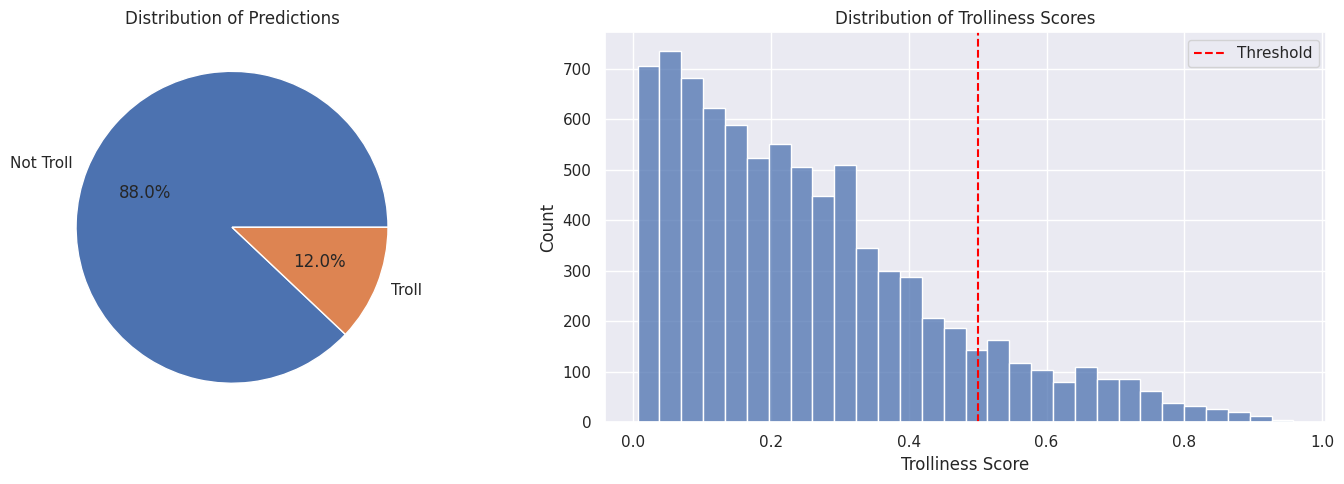


Trolliness Score Statistics:
----------------------------------------
count    8275.000000
mean        0.253288
std         0.192866
min         0.006510
25%         0.098828
50%         0.212892
75%         0.355043
max         0.958295
Name: trolliness_score, dtype: float64


In [22]:
# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Pie chart of troll vs non-troll predictions
predictions = (predictions_df['trolliness_score'] > predictor.threshold).map({True: 'Troll', False: 'Not Troll'})
prediction_counts = predictions.value_counts()

ax1.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%')
ax1.set_title('Distribution of Predictions')

# Plot 2: Distribution of trolliness scores
sns.histplot(data=predictions_df, x='trolliness_score', bins=30, ax=ax2)
ax2.axvline(x=predictor.threshold, color='red', linestyle='--', label='Threshold')
ax2.set_title('Distribution of Trolliness Scores')
ax2.set_xlabel('Trolliness Score')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTrolliness Score Statistics:")
print("-" * 40)
print(predictions_df['trolliness_score'].describe())
